In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import xarray as xr
import xgcm 
from fastjmd95 import jmd95numba 



# paths to dataset
PATH_2d = '/scratch/ab10313/pleiades/01_gulf/2d_data/'
PATH_3d = '/scratch/ab10313/pleiades/01_gulf/3d_data/'

# make diirectory for preprocessed variables
PATH_PP = '/scratch/ab10313/pleiades/01_gulf/preprcossed_data/'
#os.mkdir(PATH_PP)


# load 3d data
ds_T = xr.open_dataset(PATH_3d+'ds_T.nc',engine="h5netcdf")
ds_S = xr.open_dataset(PATH_3d+'ds_S.nc',engine="h5netcdf")
ds_W = xr.open_dataset(PATH_3d+'ds_W.nc',engine="h5netcdf")

HML = xr.open_dataset(PATH_PP+'HML.nc',engine="h5netcdf")
HML_mean = HML.mean()

dx = B.dxF.mean()
k_r = B_spectra.freq_r/dx/1e-3

In [ ]:
# new
# define depth index k that represents average HML 
k_HML = WB_cross_spectra.k.where(ds_3d.Z<HML.mean()).min(dim="k",skipna=True)

# average spectra averaged over the average HML 
WB_spectra_mld = WB_cross_spectra.sel(k=slice(0,k_HML)).mean('k')

# find wavenumber for which co-specrtum is maximal
k_r_max = WB_spectra_mld.freq_r.where(WB_spectra_mld == WB_spectra_mld.max(),drop=True)/dx/1e-3

# find corresponding lengthscale
L_max = 1/k_r_max

In [2]:
# find min and max i and j to crop to 10X10 degrees

i_min = np.max([ds_T.i.min().values, ds_S.i.min().values, ds_W.i.min().values])
i_max = np.min([ds_T.i.max().values, ds_S.i.max().values, ds_W.i.max().values])
j_min = np.max([ds_T.j.min().values, ds_S.j.min().values, ds_W.j.min().values])
j_max = np.min([ds_T.j.max().values, ds_S.j.max().values, ds_W.j.max().values])


#define slice to 480 index

if i_min+480>i_max:
    print('cropped region error in i')
elif j_min+480>j_max:
    print('cropped region error in j')
else:
    i_slice = slice(i_min,i_min+480)
    j_slice = slice(j_min,j_min+480)



In [3]:

# merge datasets

ds_3d =xr.merge([ds_T.sel(i=i_slice,j=j_slice), ds_S.sel(i=i_slice,j=j_slice), ds_W.sel(i=i_slice,j=j_slice)])


# define grids 
grid_3d = xgcm.Grid(ds_3d)




<xarray.DataArray 'Z' (k: 45)>
array([-5.00000e-01, -1.57000e+00, -2.79000e+00, -4.18500e+00,
       -5.78000e+00, -7.59500e+00, -9.66000e+00, -1.20100e+01,
       -1.46800e+01, -1.77050e+01, -2.11250e+01, -2.49900e+01,
       -2.93450e+01, -3.42400e+01, -3.97250e+01, -4.58550e+01,
       -5.26900e+01, -6.02800e+01, -6.86850e+01, -7.79650e+01,
       -8.81750e+01, -9.93700e+01, -1.11600e+02, -1.24915e+02,
       -1.39365e+02, -1.54990e+02, -1.71825e+02, -1.89900e+02,
       -2.09235e+02, -2.29855e+02, -2.51770e+02, -2.74985e+02,
       -2.99505e+02, -3.25320e+02, -3.52420e+02, -3.80790e+02,
       -4.10410e+02, -4.41255e+02, -4.73305e+02, -5.06540e+02,
       -5.40935e+02, -5.76465e+02, -6.13110e+02, -6.50855e+02,
       -6.89685e+02], dtype=float32)
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 35 36 37 38 39 40 41 42 43 44
    drF      (k) float32 1.0 1.14 1.3 1.49 1.7 ... 34.97 36.09 37.2 38.29 39.37
    PHrefC   (k) float32 4.905 15.4 27.37 ... 6.015e+03 6.385e+03 6.766e+03
    Z        (k) float32 -0.5 -1.57 -2.79 -4.185 ... -576.5 -613.1 -650.9 -689.7
    rhoRef   (k) float32 1.025e+03 1.025e+03 1.025e+03 ... 1.03e+03 1.03e+03
Attributes:
    standard_name:  depth
    long_name:      vertical coordinate of cell center
    units:          m
    positive:       down

In [4]:
# sigma from temp and salt, using the fastjmd95 package
    
# reference density 
rho0 = 1000 #kg/m^3

# potential density anomaly 
# with the reference pressure of 0 dbar and ρ0 = 1000 kg m−3
sigma0 = jmd95numba.rho(ds_3d.Salt.chunk(chunks={'time': 1, 'j': ds_3d.j.size, 'i': ds_3d.i.size}),
                         ds_3d.Theta.chunk(chunks={'time': 1, 'j': ds_3d.j.size, 'i': ds_3d.i.size}), 0) - rho0

# gravity
G = 9.81 #m/s^2

# buoyancy
B = -G*sigma0/rho0
B = B.rename('Buoyancy')



In [5]:
# interp W 
W_interp = grid_3d.interp(ds_3d.W,'Z', boundary='extend')

# cospectrum of w and b at the surface

In [8]:
dx = B.dxF.mean()

In [11]:
B_drop = B.drop(['CS', 'SN', 'Depth', 'dxF', 'dyF', 'rA', 'XC', 'YC','hFacC']).fillna(0)


In [12]:
#  spectra
import xrft
B_spectra = xrft.isotropic_power_spectrum(B_drop,dim=['i','j'], 
                                           detrend='linear', window=True).compute().mean('time')

/home/ab10313/.local/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home/ab10313/.local/lib/python3.9/site-packages/xrft/xrft.py:1025: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)


In [ ]:
W_spectra = xrft.isotropic_power_spectrum(W_interp,dim=['i','j'], 
                                           detrend='linear', window=True).compute().mean('time')
del W_drop

/home/ab10313/.local/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


In [ ]:
WB_cross_spectra = (W_spectra*np.conjugate(B_spectra)).real

In [ ]:
k_r = B_spectra.freq_r/dx/1e-3

In [ ]:
#save spectra
B_spectra.to_netcdf(PATH_PP+'B_spectra.nc',engine='h5netcdf')
W_spectra.to_netcdf(PATH_PP+'W_spectra.nc',engine='h5netcdf')

In [ ]:
import matplotlib.colors as colors

plt.pcolor(k_r, ds_T.Z, WT_cross_spectra, cmap='Blues')
plt.xscale("log")
plt.xlabel('k_r')
plt.ylabel('Z (m)')
plt.colorbar()
plt.title('isotropic wb cross-spectrum')

In [ ]:
###################################

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import xarray as xr
import xgcm 
from fastjmd95 import jmd95numba 



# paths to dataset
PATH_2d = '/scratch/ab10313/pleiades/01_gulf/2d_data/'
PATH_3d = '/scratch/ab10313/pleiades/01_gulf/3d_data/'

# make diirectory for preprocessed variables
PATH_PP = '/scratch/ab10313/pleiades/01_gulf/preprcossed_data/'
#os.mkdir(PATH_PP)


# load 3d data
ds_T = xr.open_dataset(PATH_3d+'ds_T.nc',engine="h5netcdf")
ds_S = xr.open_dataset(PATH_3d+'ds_S.nc',engine="h5netcdf")
ds_W = xr.open_dataset(PATH_3d+'ds_W.nc',engine="h5netcdf")



# find min and max i and j to crop to 10X10 degrees

i_min = np.max([ds_T.i.min().values, ds_S.i.min().values, ds_W.i.min().values])
i_max = np.min([ds_T.i.max().values, ds_S.i.max().values, ds_W.i.max().values])
j_min = np.max([ds_T.j.min().values, ds_S.j.min().values, ds_W.j.min().values])
j_max = np.min([ds_T.j.max().values, ds_S.j.max().values, ds_W.j.max().values])


#define slice to 480 index

if i_min+480>i_max:
    print('cropped region error in i')
elif j_min+480>j_max:
    print('cropped region error in j')
else:
    i_slice = slice(i_min,i_min+480)
    j_slice = slice(j_min,j_min+480)



# merge datasets

ds_3d =xr.merge([ds_T.sel(i=i_slice,j=j_slice), ds_S.sel(i=i_slice,j=j_slice), ds_W.sel(i=i_slice,j=j_slice)])


# define grids 
grid_3d = xgcm.Grid(ds_3d)


# sigma from temp and salt, using the fastjmd95 package
    
# reference density 
rho0 = 1000 #kg/m^3

# potential density anomaly 
# with the reference pressure of 0 dbar and ρ0 = 1000 kg m−3
sigma0 = jmd95numba.rho(ds_3d.Salt.chunk(chunks={'time': 1, 'j': ds_3d.j.size, 'i': ds_3d.i.size}),
                         ds_3d.Theta.chunk(chunks={'time': 1, 'j': ds_3d.j.size, 'i': ds_3d.i.size}), 0) - rho0

# gravity
G = 9.81 #m/s^2

# buoyancy
B = -G*sigma0/rho0
B = B.rename('Buoyancy')


del sigma0


# interp W 
W_interp = grid_3d.interp(ds_3d.W,'Z', boundary='extend')

del grid_3d, ds_3d


# # cospectrum of w and b at the surface

B_drop = B.drop(['CS', 'SN', 'Depth', 'dxF', 'dyF', 'rA', 'XC', 'YC','hFacC']).fillna(0)
del B


In [8]:
W_interp = W_interp.chunk(chunks={'time': 1, 'j': W_interp.j.size, 'i': W_interp.i.size, 'k': W_interp.k.size})

In [10]:
W_interp

,Array,Chunk
Bytes,33.36 GiB,39.72 MiB
Shape,"(860, 45, 481, 481)","(1, 45, 481, 481)"
Count,860 Tasks,860 Chunks
Type,float32,numpy.ndarray


In [11]:
B_drop

<xarray.DataArray 'Buoyancy' (time: 860, k: 45, j: 481, i: 481)>
dask.array<where, shape=(860, 45, 481, 481), dtype=float64, chunksize=(1, 45, 481, 481), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 16224 16225 16226 16227 16228 ... 16701 16702 16703 16704
  * j        (j) int64 9559 9560 9561 9562 9563 ... 10036 10037 10038 10039
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 35 36 37 38 39 40 41 42 43 44
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-11-15T12:00:00
    drF      (k) float32 dask.array<chunksize=(45,), meta=np.ndarray>
    PHrefC   (k) float32 dask.array<chunksize=(45,), meta=np.ndarray>
    Z        (k) float32 dask.array<chunksize=(45,), meta=np.ndarray>
    rhoRef   (k) float32 dask.array<chunksize=(45,), meta=np.ndarray>

In [26]:
#  spectra
import xrft


WB_cross_spectra = xrft.isotropic_cross_spectrum(W_interp, B_drop, dim=['i','j'], 
                                           detrend='linear', window=True).compute().mean('time')


#save spectra
WB_cross_spectra.real.to_netcdf(PATH_PP+'WB_cross_spectra_new.nc',engine='h5netcdf')

/home/ab10313/.local/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home/ab10313/.local/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home/ab10313/.local/lib/python3.9/site-packages/xrft/xrft.py:1025: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)

KeyboardInterrupt



In [28]:
WB_cross_spectra.real.to_netcdf(PATH_PP+'WB_cross_spectra_new.nc',engine='h5netcdf')

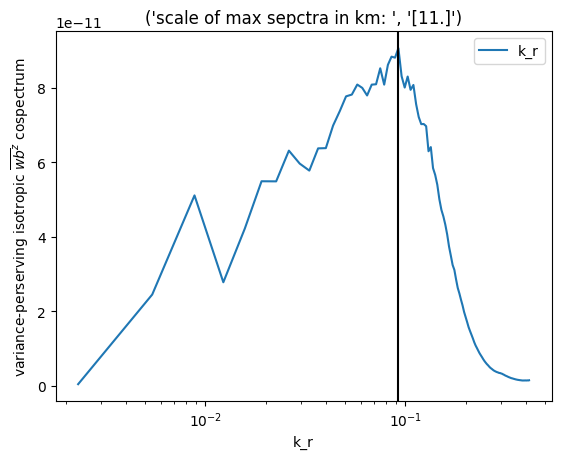

In [29]:
# load 3d data
PATH_3d = '/scratch/ab10313/pleiades/01_gulf/3d_data/'
ds_T = xr.open_dataset(PATH_3d+'ds_T.nc',engine="h5netcdf")
HML = xr.open_dataarray(PATH_PP+'HML.nc',engine="h5netcdf")


k_HML = WB_cross_spectra.k.where(ds_T.Z<HML.mean()).min(dim="k",skipna=True)
WB_spectra_mld = WB_cross_spectra.real.sel(k=slice(0,k_HML)).mean('k')#plt.plot(B_spectra.freq_r,WB_spectra_mld,label='r')

dx = ds_T.dxF.mean()
k_r = WB_cross_spectra.freq_r/dx/1e-3
k_r_max = WB_spectra_mld.freq_r.where(WB_spectra_mld*k_r == (WB_spectra_mld*k_r).max(),drop=True)/dx/1e-3
L_max = 1/k_r_max

plt.plot(k_r,WB_spectra_mld*k_r,label='k_r')
plt.axvline(k_r_max, color='black')
plt.legend()
plt.xscale("log")
plt.xlabel('k_r')
plt.ylabel('variance-perserving isotropic $\overline{wb}^z$ cospectrum')
plt.title(('scale of max sepctra in km: ',str(L_max.values.round())));

Text(0.5, 1.0, 'isotropic wb cross-spectrum')

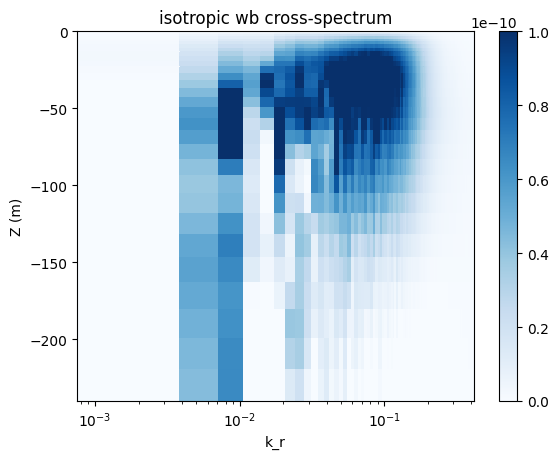

In [37]:
plt.pcolor(k_r, ds_T.Z[:30], WB_cross_spectra.real[:30,:]*k_r, cmap='Blues', vmin=0, vmax=1e-10)
plt.xscale("log")
plt.xlabel('k_r')
plt.ylabel('Z (m)')
plt.colorbar()
plt.title('isotropic wb cross-spectrum')

In [38]:
# save max over mixed layer depth average
# load 3d data
ds_T = xr.open_dataset(PATH_3d+'ds_T.nc',engine="h5netcdf")
HML = xr.open_dataarray(PATH_PP+'HML.nc',engine="h5netcdf")

k_HML = WB_cross_spectra.k.where(ds_T.Z<HML.mean()).min(dim="k",skipna=True)
WB_spectra_mld = WB_cross_spectra.real.sel(k=slice(0,k_HML)).mean('k')

dx = ds_T.dxF.mean()
k_r = WB_cross_spectra.freq_r/dx/1e-3
k_r_max = WB_spectra_mld.freq_r.where(WB_spectra_mld*k_r == (WB_spectra_mld*k_r).max(),drop=True)/dx/1e-3
L_max = 1/k_r_max

(WB_spectra_mld*k_r).to_netcdf(PATH_PP+'WB_kr_cross_spectra_mld.nc',engine='h5netcdf')
k_r_max.to_netcdf(PATH_PP+'k_r_max_mld.nc',engine='h5netcdf')


In [42]:
WB_kr_cross_spectra_mld = xr.open_dataarray(PATH_PP+'WB_kr_cross_spectra_mld.nc',engine="h5netcdf")

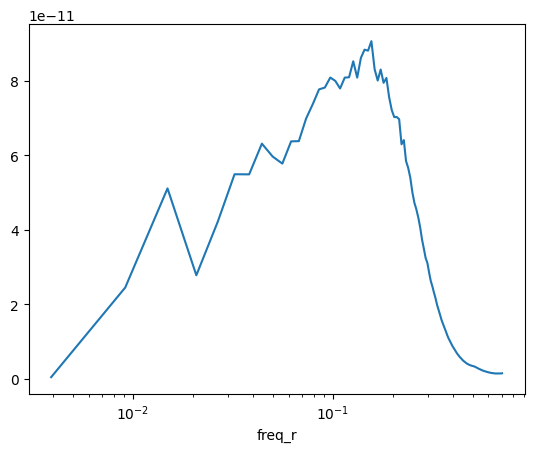

In [45]:
WB_kr_cross_spectra_mld.plot()
plt.xscale("log")